In [1]:
import numpy as np
import random
import torch
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import cifar10_model_drop_bn as cifar10_model_drop_bn
model_file="cifar10_model_drop_bn.pt"
epochs=100
patience = 5
best_loss = float('inf')
counter = 0
# end_loss=0.65

In [3]:
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 隨機裁剪圖像
    transforms.RandomHorizontalFlip(),     # 隨機水平翻轉圖像
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616))
])

In [5]:
train_data=datasets.CIFAR10('data/cifar10/train',train=True,download=True,transform=transform)
print(train_data.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [6]:
dev_size=0.2
idx=list(range(len(train_data)))
np.random.shuffle(idx)
split_size=int(np.floor(dev_size*len(train_data)))
train_idx, dev_idx=idx[split_size:], idx[:split_size]
train_sampler=SubsetRandomSampler(train_idx)
dev_sampler=SubsetRandomSampler(dev_idx)

In [7]:
batch_size=1000
train_loader= DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
dev_loader= DataLoader(train_data,batch_size=batch_size,sampler=dev_sampler)
print(len(train_loader),len(dev_loader))

40 10


In [8]:
data_batch,label_batch=next(iter(train_loader))
print(data_batch.size(),label_batch.size())

torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [9]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"deivce:{device}")

deivce:cuda


In [10]:
model=cifar10_model_drop_bn.CNN().to(device)

In [11]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)

In [12]:
train_losses=[]
dev_losses=[]
x_axis=[]

for epoch in range(epochs+1):
    train_loss=0
    # 訓練資料
    model.train()
    for data,target in tqdm(train_loader):        
        data=data.to(device)
        target=target.to(device)
        
        pred=model(data)
        loss=loss_function(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss=train_loss/len(train_loader)
    
    x_axis.append(epoch)
    with torch.no_grad():
        dev_loss=0
        # 驗證資料
        model.eval()
        for data_dev,target_dev in tqdm(dev_loader):               
            data_dev=data_dev.to(device)
            target_dev=target_dev.to(device)

            dev_pred=model(data_dev)
            loss2=loss_function(dev_pred,target_dev)
            dev_loss += loss2.item()

        dev_loss=dev_loss/len(dev_loader)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    print(f"epoch: {epoch}, Train_loss: {train_loss:.3f}, Valid_loss: {dev_loss:.3f}, lr: {scheduler.get_last_lr()}")
    
    scheduler.step()
    
    if dev_loss < best_loss:
        best_loss = dev_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping at epoch', epoch)
            break

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


epoch: 0, Train_loss: 1.770, Valid_loss: 1.548, lr: [0.001]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 1, Train_loss: 1.349, Valid_loss: 1.261, lr: [0.0009996145181203615]


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


epoch: 2, Train_loss: 1.164, Valid_loss: 1.130, lr: [0.000998458666866564]


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


epoch: 3, Train_loss: 1.025, Valid_loss: 1.021, lr: [0.0009965342284774632]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


epoch: 4, Train_loss: 0.936, Valid_loss: 0.895, lr: [0.0009938441702975688]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 5, Train_loss: 0.876, Valid_loss: 0.827, lr: [0.0009903926402016151]


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


epoch: 6, Train_loss: 0.819, Valid_loss: 0.754, lr: [0.0009861849601988382]


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


epoch: 7, Train_loss: 0.770, Valid_loss: 0.723, lr: [0.0009812276182268236]


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


epoch: 8, Train_loss: 0.745, Valid_loss: 0.724, lr: [0.0009755282581475768]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 9, Train_loss: 0.714, Valid_loss: 0.705, lr: [0.0009690956679612421]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


epoch: 10, Train_loss: 0.694, Valid_loss: 0.667, lr: [0.0009619397662556433]


100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


epoch: 11, Train_loss: 0.666, Valid_loss: 0.655, lr: [0.0009540715869125406]


100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


epoch: 12, Train_loss: 0.651, Valid_loss: 0.667, lr: [0.0009455032620941839]


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


epoch: 13, Train_loss: 0.624, Valid_loss: 0.633, lr: [0.0009362480035363986]


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


epoch: 14, Train_loss: 0.609, Valid_loss: 0.596, lr: [0.0009263200821770461]


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


epoch: 15, Train_loss: 0.599, Valid_loss: 0.587, lr: [0.0009157348061512728]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


epoch: 16, Train_loss: 0.573, Valid_loss: 0.590, lr: [0.0009045084971874739]


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


epoch: 17, Train_loss: 0.568, Valid_loss: 0.571, lr: [0.0008926584654403725]


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


epoch: 18, Train_loss: 0.552, Valid_loss: 0.557, lr: [0.0008802029828000156]


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


epoch: 19, Train_loss: 0.543, Valid_loss: 0.608, lr: [0.0008671612547178428]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


epoch: 20, Train_loss: 0.532, Valid_loss: 0.551, lr: [0.0008535533905932737]


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


epoch: 21, Train_loss: 0.515, Valid_loss: 0.542, lr: [0.0008394003727664709]


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


epoch: 22, Train_loss: 0.510, Valid_loss: 0.527, lr: [0.0008247240241650919]


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


epoch: 23, Train_loss: 0.494, Valid_loss: 0.546, lr: [0.000809546974654917]


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


epoch: 24, Train_loss: 0.486, Valid_loss: 0.543, lr: [0.0007938926261462366]


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


epoch: 25, Train_loss: 0.483, Valid_loss: 0.533, lr: [0.0007777851165098012]


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


epoch: 26, Train_loss: 0.467, Valid_loss: 0.507, lr: [0.0007612492823579744]


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


epoch: 27, Train_loss: 0.459, Valid_loss: 0.542, lr: [0.0007443106207484776]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


epoch: 28, Train_loss: 0.452, Valid_loss: 0.507, lr: [0.0007269952498697734]


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


epoch: 29, Train_loss: 0.445, Valid_loss: 0.490, lr: [0.0007093298687687142]


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


epoch: 30, Train_loss: 0.440, Valid_loss: 0.496, lr: [0.000691341716182545]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


epoch: 31, Train_loss: 0.428, Valid_loss: 0.483, lr: [0.0006730585285387465]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


epoch: 32, Train_loss: 0.427, Valid_loss: 0.516, lr: [0.0006545084971874737]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


epoch: 33, Train_loss: 0.414, Valid_loss: 0.494, lr: [0.0006357202249325371]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


epoch: 34, Train_loss: 0.407, Valid_loss: 0.511, lr: [0.0006167226819279528]


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


epoch: 35, Train_loss: 0.395, Valid_loss: 0.486, lr: [0.0005975451610080642]


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


epoch: 36, Train_loss: 0.395, Valid_loss: 0.481, lr: [0.0005782172325201155]


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


epoch: 37, Train_loss: 0.389, Valid_loss: 0.485, lr: [0.0005587686987289189]


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


epoch: 38, Train_loss: 0.383, Valid_loss: 0.494, lr: [0.0005392295478639225]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


epoch: 39, Train_loss: 0.367, Valid_loss: 0.462, lr: [0.0005196299078795343]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 40, Train_loss: 0.364, Valid_loss: 0.478, lr: [0.0005]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


epoch: 41, Train_loss: 0.364, Valid_loss: 0.462, lr: [0.00048037009212046586]


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


epoch: 42, Train_loss: 0.352, Valid_loss: 0.460, lr: [0.00046077045213607765]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 43, Train_loss: 0.350, Valid_loss: 0.469, lr: [0.0004412313012710813]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


epoch: 44, Train_loss: 0.346, Valid_loss: 0.469, lr: [0.00042178276747988476]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


epoch: 45, Train_loss: 0.332, Valid_loss: 0.450, lr: [0.000402454838991936]


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


epoch: 46, Train_loss: 0.334, Valid_loss: 0.449, lr: [0.00038327731807204744]


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


epoch: 47, Train_loss: 0.329, Valid_loss: 0.466, lr: [0.00036427977506746286]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


epoch: 48, Train_loss: 0.321, Valid_loss: 0.461, lr: [0.00034549150281252644]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


epoch: 49, Train_loss: 0.319, Valid_loss: 0.449, lr: [0.00032694147146125374]


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


epoch: 50, Train_loss: 0.315, Valid_loss: 0.447, lr: [0.0003086582838174553]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


epoch: 51, Train_loss: 0.311, Valid_loss: 0.458, lr: [0.00029067013123128623]


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


epoch: 52, Train_loss: 0.305, Valid_loss: 0.455, lr: [0.0002730047501302268]


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


epoch: 53, Train_loss: 0.299, Valid_loss: 0.458, lr: [0.0002556893792515226]


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


epoch: 54, Train_loss: 0.300, Valid_loss: 0.454, lr: [0.00023875071764202575]


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


epoch: 55, Train_loss: 0.293, Valid_loss: 0.446, lr: [0.000222214883490199]


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


epoch: 56, Train_loss: 0.287, Valid_loss: 0.446, lr: [0.00020610737385376362]


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


epoch: 57, Train_loss: 0.288, Valid_loss: 0.452, lr: [0.00019045302534508325]


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


epoch: 58, Train_loss: 0.287, Valid_loss: 0.443, lr: [0.00017527597583490834]


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


epoch: 59, Train_loss: 0.280, Valid_loss: 0.436, lr: [0.00016059962723352931]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 60, Train_loss: 0.279, Valid_loss: 0.442, lr: [0.00014644660940672636]


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


epoch: 61, Train_loss: 0.272, Valid_loss: 0.448, lr: [0.00013283874528215725]


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


epoch: 62, Train_loss: 0.271, Valid_loss: 0.442, lr: [0.0001197970171999846]


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


epoch: 63, Train_loss: 0.271, Valid_loss: 0.442, lr: [0.00010734153455962753]


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

epoch: 64, Train_loss: 0.269, Valid_loss: 0.449, lr: [9.549150281252638e-05]
Early stopping at epoch 64


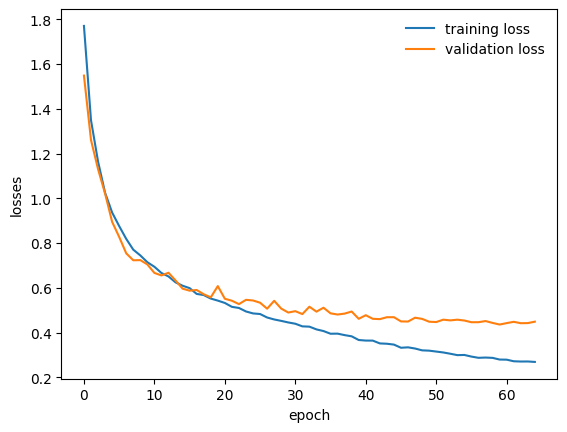

In [13]:
plt.plot(x_axis,train_losses,label="training loss")
plt.plot(x_axis,dev_losses,label="validation loss")
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

In [14]:
model=model.to("cpu")
torch.save(model.state_dict(),model_file)